# Useful Links
- [Example of very basic UNet for Semantic Segmentation](https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705)
- [Step-by-Step-Guide: Semantic Segmentation using PyTorch FCN ResNet](https://debuggercafe.com/semantic-segmentation-using-pytorch-fcn-resnet/)
- [Simple Implementation of ResNet (Source for Code)](https://github.com/usuyama/pytorch-unet/blob/master/helper.py)
- [Very sophisticated implementation of PyTorch-ENet](https://github.com/davidtvs/PyTorch-ENet)

# TO DO LIST

**AGREED SETTINGS**:
- try different activations
  - ReLu
  - tanh
  - sigmoid
- change learning rate ('lr')
  - 1e-2
  - 1e-3
  - 1e-4
- batches
  - 32
  - 64

**BACKLOG**:
- plot bounding boxes incl. class name

**OPEN**:
- understand sampler
- understand implementation of [skip connections](https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705)
- plot train vs. validation loss
- check implementation in papers of Uni Bonn


**IN PROGRESS**:

**DONE**:
- find error in data: there seems to be a target image with 6 channels?
    - when training with all images
- stay with Adam (to not increase settings too much)
- switch from dice loss to IoU: 
  - [kaggle function library](https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch)
  - https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
- change input dataset
- understand how batches/inputs are passed to model
  - transformation ?
- change num_epochs to 30
- un-freeze backbone

# ENV Setup

## Enabling GPU on Colab

Need to enable GPU from Notebook settings

- Navigate to Edit-Notebook settings menu
- Select GPU from the Hardware Accelerator dropdown list

In [ ]:
import torch
if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla V100-SXM2-16GB


## Imports

In [ ]:
!pip install loguru

     |████████████████████████████████| 61kB 3.6MB/s 


In [ ]:
# import standard packages
import pandas as pd
import cv2
import torch
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict, Counter
from PIL import Image
from sklearn.model_selection import train_test_split
import json
from loguru import logger
from functools import reduce
import seaborn as sns
import json

# import torch modules
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torchvision.models
from torchvision import transforms
from torchsummary import summary
import torchvision.utils

## Authentication

### Gdrive

In [ ]:
# connect colab to drive files
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### GSheets

In [ ]:
# connect to google sheets: authentication
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

## User Inputs

### fixed inputs/paths

In [ ]:
## FILE PATHS

# set working directory for simplified imports
img_data_path = "/content/gdrive/My Drive/Computer Vision Project/"
gs_resnet18_in_ws_url = 'https://docs.google.com/spreadsheets/d/10TXuAS9ahjj15bH4BMXLe1D41pvzz0ZPtdNbRnpD3us/edit#gid=0'
gs_resnet18_in_ws_name = 'resnet18_in'
gs_resnet18_out_ws_url = 'https://docs.google.com/spreadsheets/d/10TXuAS9ahjj15bH4BMXLe1D41pvzz0ZPtdNbRnpD3us/edit#gid=105613850'
gs_resnet18_out_ws_name = 'resnet18_out'

## CHECKPOINT FOR SAVING LOSSES AND MODELS
checkpoint_path = "/content/gdrive/My Drive/Computer Vision Project/model_states/ResNet/checkpoints/" #"checkpoint.pth"
log_file_path = "/content/gdrive/My Drive/Computer Vision Project/model_states/ResNet/logs/"
loss_json_path = "/content/gdrive/My Drive/Computer Vision Project/model_states/ResNet/losses/"

## RANDOM SEED
seed = 43
torch.manual_seed(seed)

## GENERAL MODEL SETTINGS
num_class = 3 # sugar beets vs. weed (=unkraut) vs. background
choose_imported_settings = True
model_id = 10

## SET SEGMENTATION MASK
# - specify here so it can be used throught entire process
palette = torch.from_numpy(np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]]))

### import settings vs. manual settings (model params)

In [ ]:
if choose_imported_settings: 

  # open resnet sheet in results-overview
  resnet_worksheet_in = gc.open_by_url(gs_resnet18_in_ws_url).worksheet(gs_resnet18_in_ws_name)

  # get data already included and convert to pandas df
  resnet_settings_gs = pd.DataFrame(resnet_worksheet_in.get_all_values())
  resnet_settings_gs.columns = resnet_settings_gs.iloc[0]
  resnet_settings_gs = resnet_settings_gs.iloc[1:]
  display(resnet_settings_gs.head())

  # get respective row from settings sheet & convert to dict
  if not model_id:
    # get settings of last row if no specific model_id given
    idx = len(resnet_settings_gs)-1
  else:
    idx = resnet_settings_gs[resnet_settings_gs['model_id']==str(model_id)].index[0] -1

  settings_dict = resnet_settings_gs.iloc[idx].to_dict()

else: 

  settings_dict = {  
    'model_id': '1',
    'model_name': 'resnet18',
    'num_epochs': '2', #num_epochs = 2
    'batch_size': '30', 
    'learning_rate': '1e-4', 
    'num_images': '100', # all images: -99
    'test_size': '0.3', # split into training vs. validatio/test set
    'test_val_size': '0.5', #split test set again into validation and test set
    'activation': 'relu',
    'unfreeze_backbone': 'False' 
    }

print(settings_dict)

,model_id,model_name,num_epochs,batch_size,learning_rate,num_images,test_size,test_val_size,activation,unfreeze_backbone,beta,lr_scheduler_step_size,loss_metric
1,1,resnet18,5,32,"1,00E-04",-99,0.3,0.5,relu,FALSE,0,8,miou
2,2,resnet18,30,32,"1,00E-04",200,0.4,0.6,relu,TRUE,0,8,miou
3,3,resnet18,3,32,"1,00E-04",100,0.3,0.5,relu,FALSE,0,8,miou
4,4,resnet18,30,32,"1,00E-04",100,0.3,0.5,relu,TRUE,0,8,miou
5,5,resnet18,30,32,"1,00E-04",-99,0.3,0.5,relu,TRUE,0,8,miou


{'model_id': '10', 'model_name': 'resnet18', 'num_epochs': '30', 'batch_size': '32', 'learning_rate': '1,00E-04', 'num_images': '-99', 'test_size': '0.3', 'test_val_size': '0.5', 'activation': 'relu', 'unfreeze_backbone': 'TRUE', 'beta': '9,90E-01', 'lr_scheduler_step_size': '8', 'loss_metric': 'wiou_ens'}


## Logger Setup

In [ ]:
import sys
def setup_logger() -> None:
    """Set up stderr logging format.

    The logging format and colors can be overridden by setting up the
    environment variables such as ``LOGURU_FORMAT``.
    See `Loguru documentation`_ for details.

    .. _Loguru documentation: https://loguru.readthedocs.io/en/stable/api/logger.html#env
    """
    # logger.remove()  # Remove the default setting

    # # Set up the preferred logging colors and format unless overridden by its environment variable
    # logger.level("INFO")
    # log_format = (
    #     # "<green>{time:YYYY-MM-DD HH:mm:ss}</green> "
    #     "<b><level>{level: <8}</level></b> "
    #     "| <level>{message}</level>"
    # )
    # logger.add(sys.stdout, format=log_format)

    # specify storage of log file
    logger.add(log_file_path + f"model{int(settings_dict['model_id'])}_{datetime.now().strftime('%Y%m%d_%H-%M-%S')}.log")

    # # By default all the logging messages are disabled
    # logger.enable("charger") 

setup_logger()

## Functions

In [ ]:
def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item


def sort_and_deduplicate(l):
    return list(uniq(sorted(l, reverse=True)))


def get_palette(input_image):
  list= []
  img_shape = input_image.shape
  for i in range(img_shape[0]):
    for j in range(img_shape[1]):
        list.append(input_image[i,j,:].tolist())
  palette = sort_and_deduplicate(list)
  return palette


def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = [torch.all(torch.eq(mask, colour), dim=-1) for colour in palette]
    semantic_map = torch.stack(semantic_map, dim=-1).float()
    return semantic_map


def onehot_to_mask(mask, palette):
    """
    Converts a mask (H, W, K) to (H, W, C)
    """
    indices = torch.argmax(mask, dim=-1).type(torch.LongTensor)
    color = palette[indices]
    color[(color==1)] = 255
    return color

In [ ]:
def reverse_transform(inp):
  """
  transform input tensor back to rgb-image 
  -> note: centering and scaling has to be reversed
  """
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  inp = (inp * 255).astype(np.uint8)

  return inp


def masks_to_colorimg(masks):
    colors = np.asarray([(0, 0, 0), (0, 255, 0), (0, 0, 255)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)


def plot_img_array(img_array, ncol=3):
    sns.set_style("whitegrid")

    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])
        plots[i // ncol, i % ncol].set_title(f'img no: {i // ncol}')


def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

# Data Preparation (bonobob data)

## prepare data with total relative path

In [ ]:
settings_dict['num_images']

'-99'

In [ ]:
# read in file containing path to images
path_images = pd.read_excel(img_data_path + 'notebooks/results/relations/20210529_EV_img_availability_df.xlsx').drop('Unnamed: 0', axis=1)

# set base path
base_path = img_data_path + 'data/raw/ijrr_sugarbeets_2016_annotations_part04'
path_images = path_images[['nir', 'colorCleaned', 'id', 'cka']].dropna()

data_dict = {}

for index, row in path_images.iterrows():
  nir = f'{base_path}/{row.cka}/images/nir/{row.nir}.png'
  color_cleaned = f'{base_path}/{row.cka}/annotations/dlp/colorCleaned/{row.colorCleaned}.png'
  id = row.id
  data_dict[index] = {'id': id,'image': nir,'label': color_cleaned}

data = pd.DataFrame.from_dict(data_dict, orient='index')
logger.info(f'#images: {len(data)}')

## for testing of function: take only first 100 images
if settings_dict['num_images'] != '-99': #-99 as indicator for choosing all images
  data = data.iloc[0:int(settings_dict['num_images'])]
else:
  num_images = len(data) #set # images for printing to evaluation sheet
logger.info(f'#images in selected subset:{len(data)}')
display(data)

2021-06-27 17:59:10.783 | INFO     | __main__:<module>:17 - #images: 11552
2021-06-27 17:59:10.785 | INFO     | __main__:<module>:24 - #images in selected subset:11552


,id,image,label
0,bonirob_2016-05-10-11-29-18_13_frame187,/content/gdrive/My Drive/Computer Vision Proje...,/content/gdrive/My Drive/Computer Vision Proje...
1,bonirob_2016-05-10-11-39-31_15_frame201,/content/gdrive/My Drive/Computer Vision Proje...,/content/gdrive/My Drive/Computer Vision Proje...
2,bonirob_2016-05-10-11-34-24_14_frame278,/content/gdrive/My Drive/Computer Vision Proje...,/content/gdrive/My Drive/Computer Vision Proje...
3,bonirob_2016-05-10-11-39-31_15_frame206,/content/gdrive/My Drive/Computer Vision Proje...,/content/gdrive/My Drive/Computer Vision Proje...
4,bonirob_2016-05-10-11-34-24_14_frame207,/content/gdrive/My Drive/Computer Vision Proje...,/content/gdrive/My Drive/Computer Vision Proje...
...,...,...,...
12907,bonirob_2016-05-06-11-21-29_10_frame209,/content/gdrive/My Drive/Computer Vision Proje...,/content/gdrive/My Drive/Computer Vision Proje...
12908,bonirob_2016-05-06-11-21-29_10_frame184,/content/gdrive/My Drive/Computer Vision Proje...,/content/gdrive/My Drive/Computer Vision Proje...
12909,bonirob_2016-05-06-11-21-29_10_frame133,/content/gdrive/My Drive/Computer Vision Proje...,/content/gdrive/My Drive/Computer Vision Proje...
12910,bonirob_2016-05-06-11-21-29_10_frame145,/content/gdrive/My Drive/Computer Vision Proje...,/content/gdrive/My Drive/Computer Vision Proje...


In [ ]:
# ## Data Understanding: inspect sample images

# # # import nir image to check shape
# # print('image:')
# # print(data.image[0])
# # image_nir = Image.open(data.image[0]).convert("RGB")
# # print(image_nir.mode, image_nir.size)
# # print('color channels:',image_nir.getbands())

# # import label image to check shape
# from collections import Counter
# print('\nlabel:')
# print(data.label[0])
# image_label = Image.open(data.label[0]).convert("RGB")
# print(image_label.mode, image_label.size)
# print('color channels:',image_label.getbands())

# # check # classes
# ann_color_c = cv2.cvtColor(cv2.imread(data.label[0]), cv2.IMREAD_COLOR)
# print('distribution of colors per class:',Counter([tuple(colors) for i in ann_color_c for colors in i]))


label:
/content/gdrive/My Drive/Computer Vision Project/data/raw/ijrr_sugarbeets_2016_annotations_part04/CKA_160510/annotations/dlp/colorCleaned/bonirob_2016-05-10-11-29-18_13_frame187.png
RGB (1296, 966)
color channels: ('R', 'G', 'B')
distribution of colors per class: Counter({(0, 0, 0): 1249604, (0, 255, 0): 2110, (0, 0, 255): 222})


## create data loader with ImageDataset class and data loader method

*   [Customized Data Loader for Multi-Class Image Segmentation](https://discuss.pytorch.org/t/how-make-customised-dataset-for-semantic-segmentation/30881/16)
* [MultiClass segmentation](https://discuss.pytorch.org/t/multiclass-segmentation-u-net-masks-format/70979)



In [ ]:
# # set color palette
# palette = get_palette(label)

In [ ]:
class ImageDataset(Dataset):
    """
    Creates a PyTorch dataset from folder
    main_dir : directory where images are stored.
    transform (optional) : torchvision transforms to be applied while making dataset
    """

    def __init__(self, image, label, transform_img=None, transform_mask=None):
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.image = image
        self.label = label
        self.palette = torch.from_numpy(np.array([[255, 0, 0], [0, 255, 0], [0, 0, 0]]))
        # self.mapping = {0:0, 255:1}

    def __len__(self):
        return len(self.image)

    #   # kleine batches: bietet mehr randomisierung
    #   # - bei segmentierung: durch pro-pixel entscheidung schon pro bild viele entscheidungen
    #   # - d.h. kann sinnvoll sein, hier bereits mit sehr kleinen batch sizes zu arbeiten

    def __getitem__(self, idx):
        img_loc_nir = self.image[idx]
        img_loc_label = self.label[idx]

        # read in image as PIL image
        image_nir = Image.open(img_loc_nir).convert("RGB")
        image_label = Image.open(img_loc_label).convert("RGB")

        if self.transform_img is not None:
            tensor_image_nir = self.transform_img(image_nir)
        
        if self.transform_mask is not None:

            # (1) apply preprocess-mask: resize+centercrop  (note: this changes color values !)
            image_label = preprocess_mask(image_label)

            # (2) convert PIL -> np -> torch
            label_torch = torch.from_numpy(np.array(image_label))

            # (3a) convert values to one-hot: after resize and centercrop, some pixels at class
            #      borders have values other than 0 and 255 to encode some degree of uncertainty
            #   -> approach: everything below 128 as 0, everything above as 1
            label_torch[(label_torch<=128) & (label_torch!=0)] = 0
            label_torch[(label_torch>128)] = 1

            # (3b) convert RGB-channels into segmentation mask with class channels
            #   -> this will also give one-hot to background
            one_hot_label = mask_to_onehot(label_torch, palette)

            # (4) swap dimensions: #classes x h x w -> to fit input dims
            one_hot_label = one_hot_label.long().permute(2,0,1)

        return [tensor_image_nir, one_hot_label]

def create_data_loader(image_data, image_target, batch_size, transformer_img, transformer_mask, num_workers=2, sampler = None):
  
  # initialize dataset by reference to image_data paths and image_target paths given in data df
  # -> apply transformation !
  ds = ImageDataset(
    image=np.array(image_data),
    label=np.array(image_target),
    transform_img = transformer_img,
    transform_mask = transformer_mask)
  
  # initialize sampler based on given dataset -> here: RandomSampler
  if sampler!=None:
    sampler = sampler(ds)

  # return DataLoader object
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=num_workers,
    sampler = sampler
  )

## image normalization
- [Why negative values in tensor?](https://discuss.pytorch.org/t/tensor-image-with-negative-values/91505/2)
- [Source code "transforms.py"](https://github.com/pytorch/vision/blob/3c81d474a2525b11356ca1dde299a9b1ab3715c6/references/segmentation/transforms.py#L91-L92): note: only images are re-scaled, not the target masks !


In [ ]:
preprocess_img = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet
])

preprocess_mask = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
])

In [ ]:
# ## TESTING: label to one hot encoded segmentation mask

# # select sample image + label 
# img = data[data['id']=='bonirob_2016-05-10-11-29-18_13_frame187']['image'][0]
# label = data[data['id']=='bonirob_2016-05-10-11-29-18_13_frame187']['label'][0]

# ## TRANSFORMATION

# # alternative: read in label as PIL Image (note: transforms requires input as PIL image)
# img = Image.open(img).convert("RGB")
# orig_label = Image.open(label).convert("RGB")
# print('PIL: shape img & label:',img.size,image_label.size)

# # get segmentation mask color palette
# palette = torch.from_numpy(np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]]))

# # (1) apply preprocess-mask: resize+centercrop  (note: this changes color values !)
# image_label = preprocess_mask(orig_label)
# print('transformed label (preprocess_mask):', image_label.size)

# # (2) convert PIL image to torch
# label_torch = torch.from_numpy(np.array(image_label))
# print('PIL -> torch:', label_torch.shape)

# # (3a) convert values to one-hot: after resize and centercrop, some pixels at class
# #      borders have values other than 0 and 255 to encode some degree of uncertainty
# #   -> approach: everything below 128 as 0, everything above as 1
# label_torch[(label_torch<=128) & (label_torch!=0)] = 0
# label_torch[(label_torch>128)] = 1

# # (3b) convert RGB-channels into segmentation mask with class channels
# #   -> this will also give one-hot to background
# one_hot_label = mask_to_onehot(label_torch, palette)
# print('shape of one hot label:', one_hot_label.shape)
# print('distribution of colors in one_hot_label:',Counter([tuple(colors) for i in one_hot_label.numpy() for colors in i]))

# # (4) swap dimensions: #classes x h x w -> to fit input dims
# one_hot_label = one_hot_label.long().permute(2,0,1)
# print('permute:',one_hot_label.shape)

# ## VALIDATION

# # convert semantic mask back to label image
# back_label = onehot_to_mask(one_hot_label, palette)
# back_label[(back_label==1)] = 255
# print('sample backlabeled [0,0,:]:',back_label[0][0])
# print('distribution of colors in back_label:',Counter([tuple(colors) for i in back_label.numpy() for colors in i]))

# # convert tensor back to PIL image
# # back_label = Image.fromarray(back_label.numpy())

# # show labeled image (before one hot encoding vs. after)
# fig, ax = plt.subplots(1,3,sharex=True, sharey=True)
# ax[0].imshow(img)
# ax[0].set_title('input')
# ax[1].imshow(image_label)
# ax[1].set_title('original label') # before one hot
# ax[2].imshow(back_label)
# ax[2].set_title('back_label') # after one hot
# plt.show()

## split data into train and test set

In [ ]:
# generate train (0.7) and test (0.3) set
x_train, x_test, y_train, y_test = train_test_split(data.image, data.label, test_size=float(settings_dict['test_size']), random_state=seed, shuffle=True)

# split test set again into validation (0.5) and test (0.5) set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=float(settings_dict['test_val_size']), random_state=seed, shuffle=True)

# validate shapes of all sets
logger.info(f'# training samples: {len(x_train)} - {len(y_train)}' 
      f'\n# testing samples: {len(x_test)} - {len(y_test)}'
      f'\n# validation samples: {len(x_val)} - {len(y_val)}')

2021-06-27 17:59:22.544 | INFO     | __main__:<module>:8 - # training samples: 8086 - 8086
# testing samples: 1733 - 1733
# validation samples: 1733 - 1733


## define data loader
- **Transformation of test images**: If you would like to use a standard classification criterion like nn.CrossEntropyLoss, you would have to transform the colors to a class index -> If I’m correct in my assumption about the segmentation mask (different colors correspond to different classes), you should also be careful with the normalization, since this might distort your indices.

In [ ]:
# create data loader instances based on train/test/validation sets
train_data_loader = create_data_loader(x_train, y_train, int(settings_dict['batch_size']), preprocess_img, preprocess_mask, sampler = RandomSampler)
val_data_loader = create_data_loader(x_val, y_val, int(settings_dict['batch_size']), preprocess_img, preprocess_mask, sampler = RandomSampler)
test_data_loader = create_data_loader(x_test, y_test, int(settings_dict['batch_size']), preprocess_img, preprocess_mask, sampler = RandomSampler)

# generate dict of dataloaders for model training: {train_data_loader, val_data_loader}
dataloaders = {
  'train': train_data_loader,
  'val': val_data_loader
}

In [ ]:
# # initialize batch_cnt and final dict
# batch_cnt = 0
# overall_train_dist = {}

# for inputs, masks in train_data_loader:

#   # convert masks to numpy array
#   masks_np = masks.long().permute(0,2,3,1).numpy()

#   # initialize class dict
#   batch_class_dist = {}

#   # check distribution of classes in target masks
#   for k in range(0,masks_np.shape[0]):
#     batch_class_dist[k] = dict(Counter([str(tuple(colors)) for i in masks_np[k] for colors in i]))

#   # convert dict to df and compute proportional class dist
#   batch_class_dist_df = pd.DataFrame.from_dict(batch_class_dist, orient='index') / (224*224)

#   # get mean ratio per class in current batch
#   overall_train_dist[batch_cnt] = batch_class_dist_df.mean()

#   # jump to next batch
#   batch_cnt += 1

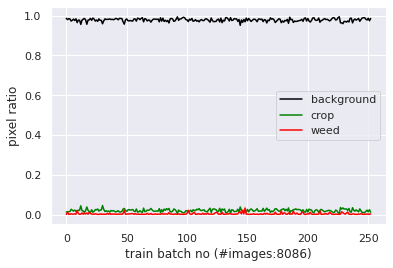

In [ ]:
# convert dict to df
overall_train_dist_df = pd.DataFrame.from_dict(overall_train_dist, orient='index')

# plot distribution over batches
overall_train_dist_df.columns
sns.set_theme()
plt.plot(overall_train_dist_df['(1, 0, 0)'], color = 'black', label='background')
plt.plot(overall_train_dist_df['(0, 1, 0)'], color = 'green', label='crop')
plt.plot(overall_train_dist_df['(0, 0, 1)'], color = 'red', label='weed')
plt.xlabel(f'train batch no (#images:{len(x_train)})')
plt.ylabel('pixel ratio')
plt.legend()
plt.show()

# print overall mean
print(overall_train_dist_df.mean())

In [ ]:
# short_data_loader = create_data_loader(x_train[0:1],y_train[0:1], int(settings_dict['batch_size']), preprocess_img, preprocess_mask, sampler = RandomSampler)

In [ ]:
# # get batch of data
# inputs, masks = next(iter(short_data_loader))
# print('inputs, masks - shape:',inputs.shape, masks.shape)

# # convert semantic mask back to label image
# back_label = onehot_to_mask(masks[0], palette)
# print('sample backlabeled [0,0,:]:',back_label[0][0])
# print('distribution of colors in back_label:',Counter([tuple(colors) for i in back_label.numpy() for colors in i]))

# # # show labeled image (before one hot encoding vs. after)
# # fig, ax = plt.subplots(1,3,sharex=True, sharey=True)
# # ax[0].imshow(img)
# # ax[0].set_title('input')
# # ax[1].imshow(image_label)
# # ax[1].set_title('original label') # before one hot
# # ax[2].imshow(back_label)
# # ax[2].set_title('back_label') # after one hot
# # plt.show()

In [ ]:
# # Get a batch of training data
# inputs, masks = next(iter(dataloaders['train']))
# print(inputs.shape,masks.shape)
# print(inputs[0].min(),inputs[0].max(), inputs[0].shape)
# print(masks[0].min(),masks[0].max(), masks[0].shape)

In [ ]:
# # plot sample from batch
# fig, ax = plt.subplots(1,2,figsize=(10,5))
# ax[0].imshow(reverse_transform(inputs[0]))
# ax[1].imshow(reverse_transform(masks[0]))

# # inspect color values per channel
# for i in range(0,3):
#   print(i,':',Counter(masks[3][i].numpy().flatten()))

# Model Defintion


## Define a UNet module

1.   **nn.Sequential**: sequential container for PyTorch modules

2.   **nn.Module**: Base class for all neural network modules, Your models should also subclass this class

3. **torchvision.models.[resnet18](https://pytorch.org/vision/stable/models.html) (pretrained=True)**
> pre-trained models, using the PyTorch torch.utils.model_zoo
> Instancing a pre-trained model will download its weights to a cache directory
> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

4. **base_model.children or base_model.named_children**: Returns an iterator over immediate children modules.

5. **bottleneck**:
> 


![UNet Architecture](https://miro.medium.com/max/576/1*vh5TSjzuPcl4OncQeDCLeA.png)

In [ ]:
def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)

    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)

    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)

    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

## Instantiate the UNet model

In [ ]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
logger.info(f'device: {device}')

# instantiate ResNetUNet Model
resnet_model = ResNetUNet(num_class).to(device)

# print model architecture
# print(resnet_model,'\n')

# Show model summaries (incl. #params)
# print(summary(resnet_model, input_size=(3, 224, 224)),'\n')

# get #params for evaluation sheet


2021-06-27 17:59:32.847 | INFO     | __main__:<module>:4 - device: cuda


cuda


# Training

## Define the loss (IoU)

*   [Frequency IoU](https://github.com/mtdo/ts-segment/blob/master/segmentation/metrics/metrics.py): not quite what we want as this is only a normalization method and not a weighting scheme !
*   [Weighting Schemes](https://medium.com/gumgum-tech/handling-class-imbalance-by-introducing-sample-weighting-in-the-loss-function-3bdebd8203b4): ISNS & ENS sound promising as they are designed to handle extreme class imbalances as prevalent in our ds
    * [Paper on ENS](https://arxiv.org/abs/1901.05555)
* [Paper on Class Imbalances](https://juser.fz-juelich.de/record/890983/files/Oskar_Class_Imbalance.pdf): explains distinction between sample and pixel imbalance
* [Alternative Loss Functions for Class Imbalances](https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5): might also be worth trying in case results don't improve !



In [ ]:
class mIoULoss(nn.Module):
  def __init__(self, weight=None, size_average=True, n_classes=3):
      super(mIoULoss, self).__init__()
      self.classes = n_classes

  def forward(self, pred, target, smooth=1e-6):
    # pred => N x Classes x H x W
    # target_oneHot => N x Classes x H x W

    N = pred.size()[0]

    # predicted probabilities for each pixel along channel
    pred = F.softmax(pred,dim=1)
    
    # Numerator Product
    inter = pred * target
    ## Sum over all pixels N x C x H x W => N x C
    inter = inter.view(N,self.classes,-1).sum(2)
    # print('inter:',inter.shape)

    #Denominator 
    union= pred + target - (pred*target)
    ## Sum over all pixels N x C x H x W => N x C
    union = union.view(N,self.classes,-1).sum(2)
    # print('union:',union.shape)

    # compute iou
    iou = (inter+smooth)/(union+smooth) # returns tensor
    # print('iou:',iou.shape)
    
    # get the mean over batches and classes
    iou_mean = iou.mean()

    ## Return average loss over classes and batch
    return 1-iou_mean

In [ ]:
class weighted_IoULoss_ens(nn.Module):

  def __init__(self, beta=0.99, n_classes=3):
      super(weighted_IoULoss_ens, self).__init__()
      self.classes = n_classes
      self.beta = beta

  def forward(self, pred, target, smooth=1e-6):

    # get batch size
    # - pred => N x Classes x H x W
    # - target_oneHot => N x Classes x H x W
    N = pred.size()[0]

    # predicted probabilities for each pixel along channel
    pred = F.softmax(pred,dim=1)
    
    # Numerator Product
    inter = pred * target
    ## Sum over all pixels N x C x H x W => N x C
    inter = inter.view(N,self.classes,-1).sum(2)
    # print('inter:',inter.shape)

    #Denominator 
    union= pred + target - (pred*target)
    ## Sum over all pixels N x C x H x W => N x C
    union = union.view(N,self.classes,-1).sum(2)
    # print('union:',union.shape)

    # compute iou
    iou = (inter+smooth)/(union+smooth) # returns tensor
    # print('iou:',iou.shape)

    # compute iou weights
    # (1) get normalized weights based on inverse number of effective data per class
    weights_ens = ((1.0-self.beta)) / ((1-torch.pow(self.beta, target.view(N,self.classes,-1).sum(2))))
    # (2) in case no samples: set weight to 0 !
    weights_ens[torch.isinf(weights_ens)] = 0 
    # (3) normalize
    weights_ens = (weights_ens.permute(1,0) / weights_ens.sum(1)).permute(1,0)
    # print('normalized weights_ens:',weights_ens)

    # get the weighted mean iou over batches and classes
    iou_mean_loss = ((1-iou) * weights_ens).sum(1).mean()

    ## Return average loss over classes and batch
    return iou_mean_loss

## Define the main training loop

1.   [Loss Function Library](https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch)

2. [F1/Dice-Score vs IoU](https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou)

2. tensor.view(-1)
  * https://stackoverflow.com/questions/50792316/what-does-1-mean-in-pytorch-view


In [ ]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    """
    params:
      - model: previously instantiated model, here: ResNet
      - optimizer: e.g. SGD/Adam
      - scheduler: scheduler for update of lr after e.g. certain #epochs
      - num_epochs: default=25
    approach:
      - each epoch has a train + validation phase
      - in each epoch all training/validation samples are evaluated
      - after training per epoch: update of lr
      - after validation per epoch: save state of model
      - after all epochs: print loss of last epoch
    returns: 
      - final (=best) model
    """

    # specify loss threshold
    best_loss = 1e10

    # initialize loss dict for plotting of loss curves
    loss_values = {}
    exec_time_per_epoch = {}

    for epoch in range(num_epochs):
        logger.info('Epoch {}/{}'.format(epoch, num_epochs - 1))
        logger.info('-' * 10)

        since = time.time()

        loss_values[epoch] = []

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # initialize/re-set metrics dict and #samples per epoch
            metrics = defaultdict(float)
            epoch_samples = 0

            # loop over batches
            batch_cnter = 1
            for inputs, labels in dataloaders[phase]:
                # store inputs/labels on gpu
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward: track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    # current loss function: IoU
                    # - function fills metrics dict
                    loss = calc_loss_iou(outputs, labels)
                    # loss = calc_loss_iou(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # (1) compute gradients
                        loss.backward()

                        # (2) update the parameters
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                # logger.info('epoch_samples:',epoch_samples)
                if batch_cnter % 40 == 0:
                  logger.info(f'*** batch: {batch_cnter} of {len(dataloaders[phase])}********************************************')

                # increase batch_cnter
                batch_cnter += 1

            # print_metrics(metrics, epoch_samples, phase)

            # calculate mean IoU for epoch
            # epoch_loss = metrics['iou'] / epoch_samples #iou loss before averaging
            epoch_loss = loss

            # print epoch loss 
            logger.info(f'*** phase: {phase} - epoch_loss: {epoch_loss.item()}********************************************')

            # store loss values in nested dict
            loss_values[epoch] += [epoch_loss.item()] # first value: train, second value: val

            # Learning rate scheduling should be applied after optimizer’s update
            if phase == 'train':
              scheduler.step()
              for param_group in optimizer.param_groups:
                  logger.info(f"LR {param_group['lr']}")

            # save the model weights (but only if model is better than previously best performing model)
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                checkpoint_path_model = f'{checkpoint_path}model{int(settings_dict["model_id"])}.pth'
                logger.info(f"saving best model to {checkpoint_path_model}")
                torch.save(model.state_dict(), checkpoint_path_model)

        # get execution time per epoch and store in dict
        time_elapsed = time.time() - since
        exec_time_per_epoch[epoch] = time_elapsed # in seconds
        logger.info('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    logger.info('Best val loss: {:4f}'.format(best_loss))

    # save loss dict to json file
    with open(f'{loss_json_path}loss_values_model{int(settings_dict["model_id"])}.json', 'w') as fp:
      json.dump(loss_values, fp)
    logger.info(f'loss_values: \n{loss_values}')

    # print exec time # in seconds
    logger.info(f'exec time per epoch: \n{exec_time_per_epoch}')

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path_model))

    return model, best_loss

## Training

1. [torch.optim.SGD/Adam](https://pytorch.org/docs/stable/optim.html):
  - construct an optimizer object, that will hold the current state and will update the parameters based on the computed gradients
  - give it an iterable containing the parameters (all should be Variable s) to optimize. Then, you can specify optimizer-specific options such as the learning rate, weight decay, etc.
  - **important**: if you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. Parameters of a model after .cuda() will be different objects with those before the call.

2. [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html):
  - provides several methods to adjust the learning rate based on the number of epochs
  - **StepLR**: Decays the learning rate of each parameter group by gamma every step_size epochs

3. [requires_grad](https://pytorch.org/docs/master/notes/autograd.html):
  - requires_grad is a flag that allows for fine-grained exclusion of subgraphs from gradient computation

In [ ]:
# test some params
print('model id:',int(settings_dict["model_id"]))
print('loss metric == wiou_ens:',settings_dict['loss_metric'] == 'wiou_ens')
print('lr scheduler step size:',settings_dict['lr_scheduler_step_size'])
print('lr:',float(settings_dict['learning_rate'].replace(',','.').replace('E','e')))

model id: 10
loss metric == wiou_ens: True
lr scheduler step size: 8
lr: 0.0001


In [ ]:
# freeze backbone layers
for l in resnet_model.base_layers:
  for param in l.parameters():
    param.requires_grad = bool(settings_dict['unfreeze_backbone'])

# construct optimizer
optimizer_ft = optim.Adam(params=filter(lambda p: p.requires_grad, 
                                        resnet_model.parameters()), 
                          lr=float(settings_dict['learning_rate'].replace(',','.').replace('E','e')))

# define loss function
if settings_dict['loss_metric'] == 'wiou_ens':
  calc_loss_iou = weighted_IoULoss_ens(n_classes = num_class, 
                                       beta=float(settings_dict['beta'].replace(',','.').replace('E','e')))
  
elif settings_dict['loss_metric'] == 'miou':
  calc_loss_iou = mIoULoss(n_classes = num_class)

# construct scheduler for adjustment of learning rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer_ft, step_size=int(settings_dict['lr_scheduler_step_size']), gamma=0.1) 

# start model training, result: final (=best) model
since = time.time()
resnet_model, mean_iou_loss = train_model(resnet_model, optimizer_ft, exp_lr_scheduler, num_epochs=int(settings_dict['num_epochs']))
time_elapsed = time.time() - since
logger.info(f'overall execution time: {time_elapsed}')

2021-06-27 18:00:00.780 | INFO     | __main__:train_model:26 - Epoch 0/29
2021-06-27 18:00:00.782 | INFO     | __main__:train_model:27 - ----------
2021-06-27 18:17:38.940 | INFO     | __main__:train_model:76 - *** batch: 40 of 253********************************************
2021-06-27 18:51:51.076 | INFO     | __main__:train_model:76 - *** batch: 120 of 253********************************************
2021-06-27 19:08:42.360 | INFO     | __main__:train_model:76 - *** batch: 160 of 253********************************************
2021-06-27 19:25:40.018 | INFO     | __main__:train_model:76 - *** batch: 200 of 253********************************************
2021-06-27 19:42:34.964 | INFO     | __main__:train_model:76 - *** batch: 240 of 253********************************************
2021-06-27 19:48:14.583 | INFO     | __main__:train_model:88 - *** phase: train - epoch_loss: 0.7869649529457092********************************************
2021-06-27 19:48:14.586 | INFO     | __main__:train

KeyboardInterrupt: ignored

# write results to google sheet
- [Google Colab + Google Sheets](https://medium.com/analytics-vidhya/colab-and-google-sheets-surprisingly-powerful-combination-for-data-science-part-1-bbbb11cbd8e)
- [Colab Snippet Import/Export](https://colab.research.google.com/notebooks/snippets/sheets.ipynb#scrollTo=6d0xJz3VzLOo)

### export new results

In [ ]:
# open workheet for results
resnet_worksheet_out = gc.open_by_url(gs_resnet18_out_ws_url).worksheet(gs_resnet18_out_ws_name)

# get data already included and convert to pandas df
resnet_results_gs = pd.DataFrame(resnet_worksheet_out.get_all_values())
resnet_results_gs.columns = resnet_results_gs.iloc[0]
resnet_results_gs = resnet_results_gs.iloc[1:]
# display(resnet_results_gs)

# get new results in respective format
results_export_dict = {'model_id':int(settings_dict["model_id"]),
                       'mean_iou':str(mean_iou_loss.item()).replace('.',','), 
                       'execution time (sec)':str(time_elapsed).replace('.',','),
                       'comment':'1-wiou_ens (Esther)'}
new_results = pd.DataFrame.from_dict(results_export_dict, orient='index').transpose()

# merge resnet_results_gs with new_results
resnet_results_gs_new = pd.concat([resnet_results_gs, new_results]).reset_index()
resnet_results_gs_new.drop(columns='index',inplace=True)
display(resnet_results_gs_new)

,model_id,mean_iou,execution time (sec),comment
0,1,"2,79","134,00",
1,3,"0,00","24,00",
2,4,"0,00","168,81",wo 1-loss
3,4,"0,94","109,02",1-miouloss
4,5,"0,73","11754,02",1-miouloss
5,6,"0,75","13107,00",1-miouloss
6,7,"0,48","9243,97",1-miouloss (smoothed)
7,5,"0,44","11699,23","updated one-hot encoding, 1-miouloss"
8,8,"0,47","15623,04","updated one-hot encoding, 1-miouloss"
9,10,"0,30","11601,76",1-wiou_ens (Esther)


In [ ]:
# write entire df back to google sheet
from gspread_dataframe import get_as_dataframe, set_with_dataframe
set_with_dataframe(resnet_worksheet_out, resnet_results_gs_new)
logger.info(f'results written back to gs:\n{new_results}')

2021-06-26 13:42:37.555 | INFO     | __main__:<module>:4 - results written back to gs:
  model_id            mean_iou execution time (sec)              comment
0       15  0,7230671644210815   11573,657943248749  1-wiou_ens (Esther)


In [ ]:
logger.stop()

## Plot loss over training epochs

/content/gdrive/My Drive/Computer Vision Project/model_states/ResNet/losses/loss_values_model10.json
       train       val
0   0.774392  0.768072
1   0.740256  0.765496
2   0.773865  0.738876
3   0.695362  0.792216
4   0.585127  0.626499
5   0.595643  0.493218
6   0.496367  0.403501
7   0.553115  0.465957
8   0.407734  0.451414
9   0.380572  0.406093
10  0.475001  0.387884
11  0.316165  0.380295
12  0.423704  0.399419
13  0.607655  0.461613
14  0.429286  0.484914
15  0.424246  0.407088
16  0.346750  0.373392
17  0.321074  0.403006
18  0.347664  0.350401
19  0.321282  0.390330
20  0.476587  0.489489
21  0.367962  0.437511
22  0.338757  0.545859
23  0.389240  0.417296
24  0.433173  0.395594
25  0.346401  0.463596
26  0.587598  0.303501
27  0.383556  0.486783
28  0.482519  0.390487
29  0.400878  0.404619


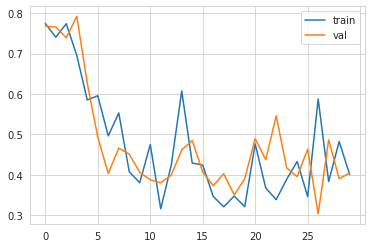

In [ ]:
# last selected model
path= f'{loss_json_path}loss_values_model{int(settings_dict["model_id"])}.json'
print(path)
#loss_values_df = pd.read_json(path).transpose()
with open(path) as f:
  data = json.load(f)
loss_values_df = pd.DataFrame(data).transpose()
loss_values_df.columns = ['train','val']
print (loss_values_df)
loss_values_df.plot()

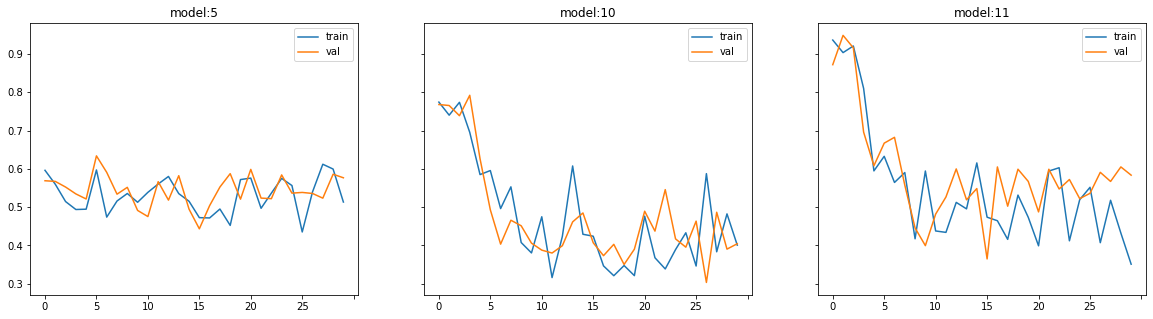

In [ ]:
# compare loss for different models

model_id_lst = [5,10,11]

fig, ax = plt.subplots(1,len(model_id_lst),sharex=False, sharey=True, figsize = (20,5))

for i in range(0,len(model_id_lst)): 
  path= f'{loss_json_path}loss_values_model{model_id_lst[i]}.json'
  with open(path) as f:
    data = json.load(f)
  loss_values_df = pd.DataFrame(data).transpose()
  loss_values_df.columns = ['train','val']
  loss_values_df.plot(ax=ax[i])
  ax[i].set_title(f"model:{model_id_lst[i]}")

# Prediction

## Predict new images using the trained model
- [Mapping of prediction classes to color map](https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/)
- [PyTorch argmax](https://pytorch.org/docs/stable/generated/torch.argmax.html)

### instantiate / load learned model

In [ ]:
# instantiate ResNetUNet Model to load fine-tuned model
resnet_model = ResNetUNet(num_class).to(device)

# load stored models
checkpoint_path_model = f'{checkpoint_path}model{int(settings_dict["model_id"])}.pth'
resnet_model.load_state_dict(torch.load(checkpoint_path_model))

# Set model to the evaluation mode
# - note: uses final (=best) model that is returned by training method
resnet_model.eval() 

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

### make prediction

In [ ]:
# Get the first batch
inputs, labels = next(iter(test_data_loader))
inputs = inputs.to(device)
labels = labels.to(device)
print('inputs.shape', inputs.shape)
print('labels.shape', labels.shape)

inputs.shape torch.Size([32, 3, 224, 224])
labels.shape torch.Size([32, 3, 224, 224])


In [ ]:
# Predict: apply final (=best) model
pred = resnet_model(inputs)
print('pred before softmax\n',pred[0])

# apply softmax
pred = F.softmax(pred,dim=1)
print('pred after softmax\n',pred[0])

# compare to predictions
print('labels\n',labels[0]) #.data.cpu().numpy()

# The loss functions includes the sigmoid function
# pred = torch.sigmoid(pred)
pred_np = pred.data.cpu().numpy()
print('pred_np.shape', pred_np.shape)

pred before softmax
 tensor([[[ 10.2133,  18.1522,  22.1177,  ...,  19.0908,  15.6067,   8.8138],
         [ 19.3645,  33.4801,  40.6246,  ...,  34.9510,  28.5426,  15.7440],
         [ 24.0071,  41.3974,  50.2316,  ...,  43.2389,  35.3172,  19.4874],
         ...,
         [ 24.8307,  42.5332,  51.4718,  ...,  49.2294,  40.1319,  22.1029],
         [ 20.4947,  35.0189,  42.3338,  ...,  40.3699,  32.8796,  18.0606],
         [ 12.8957,  21.6858,  26.2015,  ...,  24.9127,  20.2141,  10.7338]],

        [[ -3.6613,  -6.5773,  -8.0869,  ...,  -7.0132,  -5.7321,  -3.4651],
         [ -7.1517, -12.4974, -15.2145,  ..., -13.1852, -10.7789,  -6.0779],
         [ -8.9718, -15.4702, -18.8123,  ..., -16.2719, -13.2955,  -7.4112],
         ...,
         [ -9.5723, -16.1299, -19.5149,  ..., -18.5765, -15.1514,  -8.2134],
         [ -7.9502, -13.3282, -16.1004,  ..., -15.2662, -12.4513,  -6.6843],
         [ -5.4240,  -8.7339, -10.4861,  ...,  -9.7377,  -7.8794,  -3.9479]],

        [[ -4.9322,  -8

### test: miou loss per batch

In [ ]:
## TESTING: LOSS PER BATCH

# set smoothing factor
smooth=1e-6

# cnt classes
n_classes = 3

# batch size
N = pred.size()[0]

# predicted probabilities for each pixel along channel
# pred = F.softmax(pred,dim=1)

# Numerator Product
inter = pred * labels
## Sum over all pixels N x C x H x W => N x C
inter = inter.view(N,n_classes,-1).sum(2)

#Denominator 
union= pred + labels - (pred*labels)
## Sum over all pixels N x C x H x W => N x C
union = union.view(N,n_classes,-1).sum(2)

# compute iou
iou = (inter+smooth)/(union+smooth) # returns tensor
print('iou loss :\n',1-iou)
print('iou loss (sample):\n',(1-iou)[23])
print('iou loss (mean sample):',(1-iou)[23].mean())

# get the mean over batches and classes
iou_mean = iou.mean()
print('mean iou',iou_mean.item(), 'loss: 1-iou', 1-iou_mean.item())

iou loss :
 tensor([[1.3953e-04, 1.0000e+00, 7.3041e-01],
        [6.2779e-03, 1.0000e+00, 1.0000e+00],
        [1.4349e-03, 1.0000e+00, 1.0000e+00],
        [1.4668e-02, 1.0000e+00, 1.0000e+00],
        [1.4150e-03, 1.0000e+00, 2.3291e-01],
        [6.7762e-03, 1.0000e+00, 1.0000e+00],
        [1.1360e-03, 1.0000e+00, 9.3775e-01],
        [4.0856e-03, 1.0000e+00, 1.0000e+00],
        [7.3743e-04, 1.0000e+00, 5.5762e-01],
        [1.1360e-03, 1.0000e+00, 1.0000e+00],
        [1.4158e-01, 1.0000e+00, 1.0000e+00],
        [2.0528e-02, 1.0000e+00, 1.0000e+00],
        [3.7867e-04, 1.0000e+00, 9.7597e-01],
        [4.1854e-04, 1.0000e+00, 1.0000e+00],
        [9.5665e-04, 1.0000e+00, 2.2484e-01],
        [1.6063e-01, 1.0000e+00, 1.0000e+00],
        [2.0767e-02, 1.0000e+00, 1.0000e+00],
        [2.2521e-03, 1.0000e+00, 1.0000e+00],
        [1.0961e-03, 1.0000e+00, 9.1255e-01],
        [5.4309e-02, 1.0000e+00, 1.0000e+00],
        [2.3517e-03, 1.0000e+00, 2.7371e-01],
        [2.8500e-03, 1

### test: weighted iou loss per batch

In [ ]:
## TESTING: weighted IoU (ENS)

beta = 0.99
n_classes = 3

# set smoothing factor
smooth=1e-6

# Normalized weights based on inverse number of effective data per class.
weights_ens = ((1.0-beta)) / ((1-torch.pow(beta, labels.view(labels.shape[0],n_classes,-1).sum(2))))

# - in case no samples: set weight to 0 !
weights_ens[torch.isinf(weights_ens)] = 0 

# - normalize
weights_ens = (weights_ens.permute(1,0) / weights_ens.sum(1)).permute(1,0)
print(f'weights_ens:',weights_ens)

# get loss for specific sample
print(f'weighed iou (sample):',((1-iou) * weights_ens)[23]) #.mean())
# print(f'weighed iou:',(1-(iou * weights_ens))[23]) #.mean())
print(f'weighed iou (sample, mean):',((1-iou) * weights_ens).mean(1)[23]) #.mean())
# print(f'weighed iou:',((1-iou) * weights_ens)) #.mean())
print(f'weighed iou (overall):',((1-iou) * weights_ens).sum(1).mean())

# - TEST: sum over all classes == 1?
# print((weights_ens.permute(1,0) / weights_ens.sum(1)).permute(1,0).sum(1)) 

weights_ens: tensor([[0.0636, 0.9364, 0.0000],
        [0.2075, 0.2222, 0.5703],
        [0.1090, 0.2639, 0.6271],
        [0.1915, 0.1917, 0.6168],
        [0.3378, 0.6622, 0.0000],
        [0.1283, 0.1336, 0.7381],
        [0.3037, 0.6963, 0.0000],
        [0.1073, 0.7667, 0.1260],
        [0.2370, 0.7630, 0.0000],
        [0.0708, 0.1882, 0.7410],
        [0.2207, 0.2207, 0.5587],
        [0.0524, 0.0524, 0.8952],
        [0.1481, 0.8519, 0.0000],
        [0.0396, 0.2832, 0.6772],
        [0.2768, 0.7232, 0.0000],
        [0.3051, 0.3051, 0.3897],
        [0.2434, 0.2434, 0.5131],
        [0.1770, 0.3817, 0.4413],
        [0.2981, 0.7019, 0.0000],
        [0.2933, 0.2933, 0.4134],
        [0.4099, 0.5901, 0.0000],
        [0.1909, 0.3103, 0.4988],
        [0.3959, 0.6041, 0.0000],
        [0.3333, 0.3333, 0.3333],
        [0.0885, 0.1887, 0.7228],
        [0.4993, 0.5007, 0.0000],
        [0.3482, 0.6518, 0.0000],
        [0.0446, 0.0446, 0.9107],
        [0.3699, 0.6301, 0.0000],
 

In [ ]:
# get inter and union per class
iou_inter = pd.DataFrame(inter.cpu().detach().numpy())
iou_inter.rename(columns={0:'0_inter',1:'1_inter',2:'2_inter'}, inplace=True)
# display(iou_inter)

iou_union = pd.DataFrame(union.cpu().detach().numpy())
iou_union.rename(columns={0:'0_union',1:'1_union',2:'2_union'}, inplace=True)
# display(iou_union)

# get cnt of samples per class per class
iou_cnt_per_class = pd.DataFrame(labels.view(N,n_classes,-1).sum(2).cpu().detach().numpy())
iou_cnt_per_class.rename(columns={0:'0_label_cnt',1:'1_label_cnt',2:'2_label_cnt'}, inplace=True)

# get calculated iou per class over batch
iou_per_class = pd.DataFrame(iou.view(N,n_classes,-1).sum(2).cpu().detach().numpy())
iou_per_class.rename(columns={0:'0_iou',1:'1_iou',2:'2_iou'}, inplace=True)

# merge all values: inter - union - cnt samples
iou_inter_union = iou_inter.merge(iou_union, left_index=True, right_index=True, how='left')
iou_inter_union = iou_inter_union.merge(iou_cnt_per_class, left_index=True, right_index=True, how='left')
iou_inter_union = iou_inter_union.merge(iou_per_class, left_index=True, right_index=True, how='left')

# replace . by , for printing to gsheets
for col in iou_inter_union.columns:
  iou_inter_union[col] = iou_inter_union[col].apply(lambda x: str(x).replace('.',','))

display(iou_inter_union)

,0_inter,1_inter,2_inter,0_union,1_union,2_union,0_label_cnt,1_label_cnt,2_label_cnt,0_iou,1_iou,2_iou
0,"49404,1328125","597,951904296875","6,822044372558594","49571,2265625","727,2409057617188","44,62809753417969",49520,620,36,"0,9966292381286621","0,8222198486328125","0,15286435186862946"
1,"50108,390625","53,12959671020508","0,0","50122,87109375","67,1118392944336","0,4973362684249878",50117,59,0,"0,9997110962867737","0,791657567024231","2,010707930821809e-06"
2,"49287,8203125","792,863525390625","0,0","49383,1328125","883,741943359375","4,435271263122559",49326,850,0,"0,9980699419975281","0,8971663117408752","2,2546529976352758e-07"
3,"47317,9296875","2507,283935546875","20,00905990600586","47648,703125","2746,18212890625","111,88653564453125",47494,2589,93,"0,9930580854415894","0,9130071401596069","0,1788335144519806"
4,"50110,5703125","50,88456726074219","0,0","50125,1171875","56,15290832519531","9,275483131408691",50125,51,0,"0,9997097849845886","0,9061786532402039","1,0781108272794881e-07"
5,"50093,703125","61,21180725097656","0,0","50114,7890625","81,14640808105469","1,1474517583847046",50108,68,0,"0,9995792508125305","0,7543378472328186","8,714956152289233e-07"
6,"49635,8359375","345,59576416015625","3,7239956855773926","49826,6796875","399,204833984375","140,9550018310547",49716,383,77,"0,9961698651313782","0,8657103776931763","0,026419755071401596"
7,"49529,78125","508,3220520019531","0,34273168444633484","49667,328125","579,743896484375","66,47884368896484",49613,540,23,"0,9972306489944458","0,8768044710159302","0,005155515391379595"
8,"50157,16796875","17,909082412719727","0,0","50158,09375","18,832538604736328","0,0002503124997019768",50158,18,0,"0,9999815225601196","0,9509648680686951","0,003979109693318605"
9,"49788,6640625","274,9386291503906","0,0","49875,21484375","363,3291320800781","49,85369873046875",49856,320,0,"0,9982646703720093","0,7567206025123596","2,0058692484781204e-08"


#### write to google sheet for testing calculations

In [ ]:
# # open workheet for results
# resnet_worksheet_iou_test = gc.open_by_url('https://docs.google.com/spreadsheets/d/10TXuAS9ahjj15bH4BMXLe1D41pvzz0ZPtdNbRnpD3us/edit#gid=682285876').worksheet('iou_test_calc')
# resnet_worksheet_iou_test

In [ ]:
# # write entire df back to google sheet
# from gspread_dataframe import get_as_dataframe, set_with_dataframe
# set_with_dataframe(resnet_worksheet_iou_test, iou_inter_union)

## Map to color mask

In [ ]:
# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [masks_to_colorimg(x) for x in pred_np]

In [ ]:
# test: how often is each class predicted for first img in batch
Counter(pred_np[0].argmax(0).flatten())

Counter({0: 50169, 1: 7})

In [ ]:
# check distribution of classes in targets and predictions per image
for k in range(0,pred_np.shape[0]):
  print(k,':')
  print('distribution of colors in target_masks_rgb[k]:',Counter([tuple(colors) for i in target_masks_rgb[k] for colors in i]))
  # print('distribution of colors in pred:',Counter([tuple(colors) for i in pred[k].long().permute(1,2,0).cpu().numpy() for colors in i]))
  print('distribution of colors in pred_rgb[k]:',Counter([tuple(colors) for i in pred_rgb[k] for colors in i]))

0 :
distribution of colors in target_masks_rgb[k]: Counter({(0, 0, 0): 50169, (0, 255, 0): 7})
distribution of colors in pred_rgb[k]: Counter({(0, 0, 0): 50169, (0, 255, 0): 7})
1 :
distribution of colors in target_masks_rgb[k]: Counter({(0, 0, 0): 49861, (0, 255, 0): 270, (0, 0, 255): 45})
distribution of colors in pred_rgb[k]: Counter({(0, 0, 0): 49793, (0, 255, 0): 299, (0, 0, 255): 84})
2 :
distribution of colors in target_masks_rgb[k]: Counter({(0, 0, 0): 50104, (0, 255, 0): 53, (0, 0, 255): 19})
distribution of colors in pred_rgb[k]: Counter({(0, 0, 0): 50108, (0, 255, 0): 43, (0, 0, 255): 25})
3 :
distribution of colors in target_masks_rgb[k]: Counter({(0, 0, 0): 49440, (0, 255, 0): 699, (0, 0, 255): 37})
distribution of colors in pred_rgb[k]: Counter({(0, 0, 0): 49314, (0, 255, 0): 745, (0, 0, 255): 117})
4 :
distribution of colors in target_masks_rgb[k]: Counter({(0, 0, 0): 50105, (0, 255, 0): 71})
distribution of colors in pred_rgb[k]: Counter({(0, 0, 0): 50092, (0, 255, 0): 

## Plot - Left: Input image, Middle: Correct mask (Ground-truth), Rigth: Predicted mask

In [ ]:
plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

Output hidden; open in https://colab.research.google.com to view.